# Imports

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import io
import os

from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, random_split
from urllib.request import urlretrieve
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


'cuda'

# Models

## UNet

In [2]:
class UNet(nn.Module):
    def __init__(self, input_channels=4, output_channels=3):
        super(UNet, self).__init__()
        self.downStep1 = downStep(input_channels, 64, firstLayer=True)
        self.downStep2 = downStep(64, 128)
        self.downStep3 = downStep(128, 256)
        self.downStep4 = downStep(256, 512)
        self.downStep5 = downStep(512, 1024)
        # self.downStep6 = downStep(1024, 2048)

        # self.upStep1 = upStep(2048, 1024)
        self.upStep2 = upStep(1024, 512)
        self.upStep3 = upStep(512, 256)
        self.upStep4 = upStep(256, 128)
        self.upStep5 = upStep(128, 64)

        self.conv = nn.Conv2d(64, output_channels, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # print(x.shape)
        x1 = self.downStep1(x)
        # print(x1.shape)
        x2 = self.downStep2(x1)
        # print(x2.shape)
        x3 = self.downStep3(x2)
        # print(x3.shape)
        x4 = self.downStep4(x3)
        # print(x4.shape)
        x5 = self.downStep5(x4)
        # x6 = self.downStep6(x5)
        # print(x5.shape)
        # x = self.upStep1(x6, x5)
        x = self.upStep2(x5, x4)
        # print(x4.shape, x5.shape)
        x = self.upStep3(x, x3)
        # print(x.shape, x3.shape)
        x = self.upStep4(x, x2)
        x = self.upStep5(x, x1)

        x = self.conv(x)
        x = self.sigmoid(x)

        return x

class downStep(nn.Module):
    def __init__(self, inC, outC, firstLayer=False):
        super(downStep, self).__init__()
        self.firstLayer = firstLayer
        self.conv = nn.Sequential(
            nn.Conv2d(inC, outC, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(outC, outC, 3, padding=1),
            nn.ReLU())
        self.maxpool = nn.MaxPool2d(2)

    def forward(self, x):
        if not self.firstLayer:
            x = self.maxpool(x)
        x = self.conv(x)

        return x

class upStep(nn.Module):
    def __init__(self, inC, outC):
        super(upStep, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(inC, outC, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(outC, outC, 3, padding=1),
            nn.ReLU())
        self.upsampling = nn.ConvTranspose2d(inC, outC, 2, 2)

    def forward(self, x, x_down):
        x = self.upsampling(x)
        x = torch.cat([x_down, x], dim=1)
        x = self.conv(x)

        return x

# Datasets

## Manga109

In [3]:
# !pip install mega.py
!pip install xmltodict

AkkeraKanjinchou
1654
1170
[{'@id': '00001d5c', '@xmin': '106', '@ymin': '724', '@xmax': '139', '@ymax': '801', '#text': 'ず〜〜っ'}, {'@id': '00001d60', '@xmin': '1048', '@ymin': '433', '@xmax': '1086', '@ymax': '556', '#text': 'まだまだ足らないなァ…'}, {'@id': '00001d62', '@xmin': '913', '@ymin': '298', '@xmax': '969', '@ymax': '381', '#text': '化して妖となる'}, {'@id': '00001d63', '@xmin': '1460', '@ymin': '647', '@xmax': '1544', '@ymax': '842', '#text': '其は天を滅ぼす'}, {'@id': '00001d64', '@xmin': '943', '@ymin': '818', '@xmax': '988', '@ymax': '975', '#text': '魔軍なり'}, {'@id': '00001d66', '@xmin': '1440', '@ymin': '447', '@xmax': '1456', '@ymax': '549', '#text': 'フフフ…'}, {'@id': '00001d67', '@xmin': '1233', '@ymin': '256', '@xmax': '1341', '@ymax': '416', '#text': 'ぎゃあああァ'}, {'@id': '00001d68', '@xmin': '661', '@ymin': '712', '@xmax': '704', '@ymax': '811', '#text': '仏さんの有様が凄いんでしょ？'}, {'@id': '00001d69', '@xmin': '1490', '@ymin': '136', '@xmax': '1534', '@ymax': '222', '#text': 'く…来るな…！'}, {'@id': '00001d6

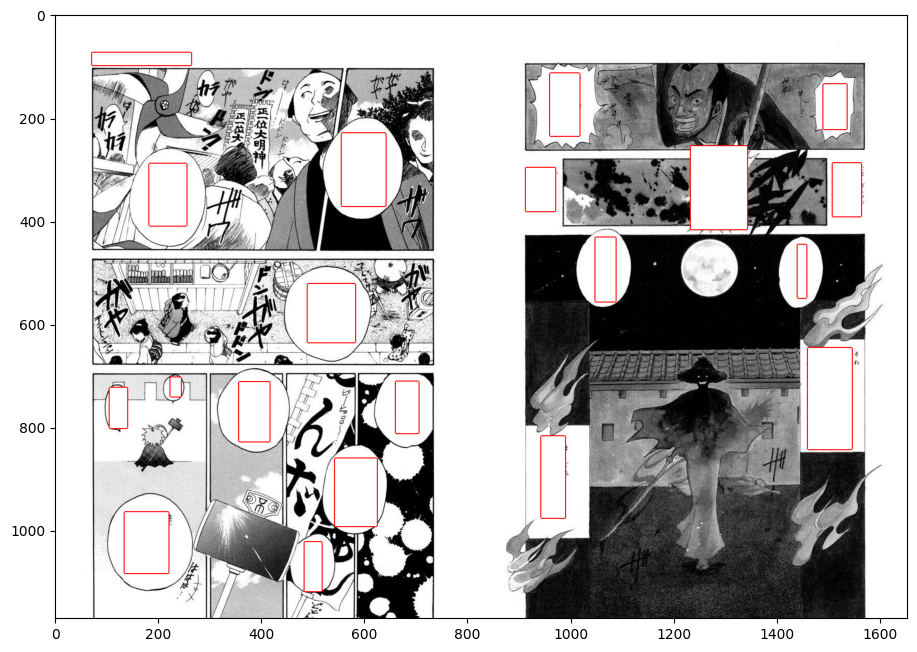

In [4]:
# import cv2
# import matplotlib.pyplot as plt
# import xmltodict



# index = 2
# page = 3
# annot_path = '/kaggle/input/manga109/Manga109/annotations.v2020.12.18/'
# annotations = [xmltodict.parse(open(annot_path + name).read()) for name in sorted(os.listdir(annot_path))]

# print(annotations[index]['book']['@title'])
# print(annotations[index]['book']['pages']['page'][page]['@width'])
# print(annotations[index]['book']['pages']['page'][page]['@height'])
# print(annotations[index]['book']['pages']['page'][page]['text'])

# img = cv2.imread('/kaggle/input/manga109/Manga109/images/' + annotations[index]['book']['@title'] + f'/00{page}.jpg')
# if type(annotations[index]['book']['pages']['page'][page]['text']) is not list:
#     print('Not a list')
# else:
#     for text in annotations[index]['book']['pages']['page'][page]['text']:
#         xmin, ymin = int(text['@xmin']), int(text['@ymin'])
#         xmax, ymax = int(text['@xmax']), int(text['@ymax'])

#         img = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), thickness=3)
#         img = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 255, 255), thickness=-1)

# plt.figure(figsize=(11, 16))
# plt.imshow(img)

In [4]:
from torch._C import dtype
import os
import xmltodict
import cv2
import torchvision.transforms as v2


transforms_output = torchvision.transforms.Compose([
    v2.ToTensor(),
    v2.Resize((1152, 1632)),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transforms_input = torchvision.transforms.Compose([
    v2.ToTensor(),
    v2.Resize((1152, 1632)),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


class MangaMasked():
    def __init__(self, root_path='/kaggle/input/manga109/Manga109/', transform_input=None, transform_output=None):
#         download_manga()
        self.root = root_path
        self.transform_input = transform_input
        self.transform_output = transform_output
        annot_path = self.root + 'annotations.v2020.12.18/'
        self.annotations = [xmltodict.parse(open(annot_path + name).read()) for name in sorted(os.listdir(annot_path))]

        self.image_infos = []
        self.masks = []
        self.width, self.height = 1654, 1170
        for i, manga in enumerate(self.annotations):
            title = manga['book']['@title']
            cnt = 0
            for j, page in enumerate(manga['book']['pages']['page']):
                page_str = page['@index']
                width, height = int(page['@width']), int(page['@height'])
                if  not os.path.isfile(self.get_image_path(title, page_str)) or width != 1654 or height != 1170:
                    continue

                self.image_infos.append((self.get_image_path(title, page_str), i, cnt))
                self.masks.append(self.find_mask(self.height, self.width, self.image_infos[-1]))
                cnt += 1

    def find_mask(self, height, width, img_info):
        texts = self.get_texts(img_info)

        def does_bbox_intersect(x_min1, y_min1, x_max1, y_max1):
            if texts is None:
                return False
            for text in texts:
                x_min2, y_min2 = int(text['@xmin']), int(text['@ymin'])
                x_max2, y_max2 = int(text['@xmax']), int(text['@ymax'])
                if (x_min1 < x_max2 and x_max1 > x_min2 and y_min1 < y_max2 and y_max1 > y_min2):
                    return True
            return False

        found = False
        x1, y1, x2, y2 = 0, 0, 0, 0
        cnt = 0
        while not found:
#             if cnt >= 10:
#                 return (-1, 0, 0, 0)
            cnt += 1
            # Generate random top-left coordinates.
            x1, y1 = np.random.randint(50, height - 50), np.random.randint(50, width - 50)
            # Generate random bottom-right coordinates
            min_w, min_h, max_w, max_h = 50, 50, 300, 300
            x2 = np.random.randint(min(x1+min_w,height), min(x1+max_w,height))
            y2 = np.random.randint(min(y1+min_h,width), min(y1+max_h,width))
            found = not does_bbox_intersect(x1, y1, x2, y2)
        return (x1, y1, x2, y2)

    def mask_image(self, img, idx) -> np.array:
        x1, y1, x2, y2 = self.masks[idx]
        # Copy original image
        masked_image = img.copy()
        # Fill black rectange on generated coordinates
        masked_image = cv2.rectangle(masked_image, (x1, y1), (x2, y2), (0, 0, 0), thickness=-1)
        # Return result
        return masked_image

    def get_mask(self, img, idx):
        x1, y1, x2, y2 = self.masks[idx]
        mask = np.zeros((img.shape[0], img.shape[1]))
        mask = cv2.rectangle(mask, (x1, y1), (x2, y2), (255), thickness=-1)
        return mask

    def get_texts(self, img_info):
        annotation = self.annotations[img_info[1]]['book']['pages']['page'][img_info[2]]
        if 'text' not in annotation:
            return None
        texts = annotation['text']
        if type(texts) is dict:
            texts = [texts]
        return texts

    def remove_texts_from_image(self, inp_img, img_info):
        img = inp_img.copy()
        mask = np.zeros((img.shape[0], img.shape[1]))
        texts = self.get_texts(img_info)
        if texts is None:
            return img
        for text in texts:
            xmin, ymin = int(text['@xmin']), int(text['@ymin'])
            xmax, ymax = int(text['@xmax']), int(text['@ymax'])
            img = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 255, 255), thickness=-1)
            mask = cv2.rectangle(mask, (x1, y1), (x2, y2), (255), thickness=-1)
        return img, mask

    def get_images_path(self, name):
        return self.root + 'images/' + name + '/'

    def get_image_path(self, name, page_str):
        page_name = '0' * (3 - len(page_str)) + page_str
        return self.get_images_path(name) + page_name + '.jpg'

    def __len__(self):
        return len(self.image_infos)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_infos[idx][0])#[:self.height, :self.width, :]
        label_img = None
        mask = None
        mask = self.get_mask(img, idx)#[..., np.newaxis]
        mask = (torch.tensor(mask[np.newaxis, ...], dtype=torch.float64))
        mask = v2.Resize((1152, 1632))(mask)
        img, label_img = self.mask_image(img, idx), img
        img = self.transform_input(img)
#         print(img.shape, mask.shape)
        img = torch.cat((img, mask), dim=0).float()
        return img, self.transform_output(label_img)
#         if sum(self.masks[idx]) == -1:
#             label_img, mask = self.remove_texts_from_image(img, self.image_infos[idx])
#         else:
#             mask = self.get_mask(img, idx)
#             img, label_img = self.mask_image(img, idx), img
# #         img = np.concatenate((img, self.get_mask(img, idx)), axis=2)
#         mask = (torch.tensor(mask[np.newaxis, ...], dtype=torch.float64))
#         img = self.transform(img)
#         img = torch.cat((img, mask), dim=0).float()
        
#         return img, self.transform(label_img)

#     def save_on_disk(self):
#         for i in range(len(self)):
#             i_str = str(i)
#             torch.save(self[i], '/kaggle/working/dataset/'+'0'*(10-len(i_str))+i_str+'.pt')

In [5]:
dataset = MangaMasked(transform_input=transforms_input, transform_output=transforms_output)

In [6]:
ind = 12
print(dataset.masks[ind])
data = dataset[ind]
print(data[0].shape, data[1].shape)

(556, 949, 831, 1022)
torch.Size([4, 1152, 1632]) torch.Size([3, 1152, 1632])


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [7]:
batch_size = 1

train_loader = DataLoader(dataset, batch_size, True)

# Train functions

## Training loop

In [8]:
# Will be done in future
def train_one_epoch(model, train_loader, optimizer, loss_fn):
    model.train()
    running_loss = 0.0
    total = 0
    data = tqdm(train_loader)#enumerate(train_loader), total=int(len(cifar10_test)/train_loader.batch_size))
    for batch in data:
        total += 1
        input, target = batch[0].to(device), batch[1].to(device)
        #print(input.shape)
        #print(target.shape)
        optimizer.zero_grad()
        outputs = model(input).to(device)
        #print(reconstruction.shape)
        loss = loss_fn(outputs, target)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
        data.set_postfix({'avg_loss': running_loss / total,'last_loss':loss.item()})
    return running_loss / total

# Model training

In [ ]:
model = UNet().to(device)

epochs = 10

optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.MSELoss()


for epoch in range(epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn)
    print(f'EPOCH: {epoch + 1} out of {epochs}, loss: {round(train_loss, 7)}\n')

  6%|▌         | 648/10503 [08:50<2:12:34,  1.24it/s, avg_loss=1.79, last_loss=1.84] 

In [ ]:
image1, image2, image3 = None, None, None

inx = 65

image1 = dataset[inx][0][:-1, :, :].permute((1, 2, 0))
image3 = dataset[inx][1].permute((1, 2, 0))

# Will be done in future
with torch.no_grad():
    model.eval()
    # result = model(img_t.view(1, 3, 32, 32).to(device))
    image2 = model(dataset[inx][0].to(device).unsqueeze(0)).cpu().squeeze(0).permute(1, 2, 0)
    # print(result[0].shape)
    # plt.imshow(result[0].permute((1,2,0)).cpu())


# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(16, 8))

axes[0].imshow(image1)
axes[0].set_title('Image with mask')

axes[1].imshow(image2)
axes[1].set_title('Model output')

axes[2].imshow(image3)
axes[2].set_title('Original image')

# Remove axis labels and ticks
for ax in axes:
    ax.axis('off')

# Display the plot
plt.show()

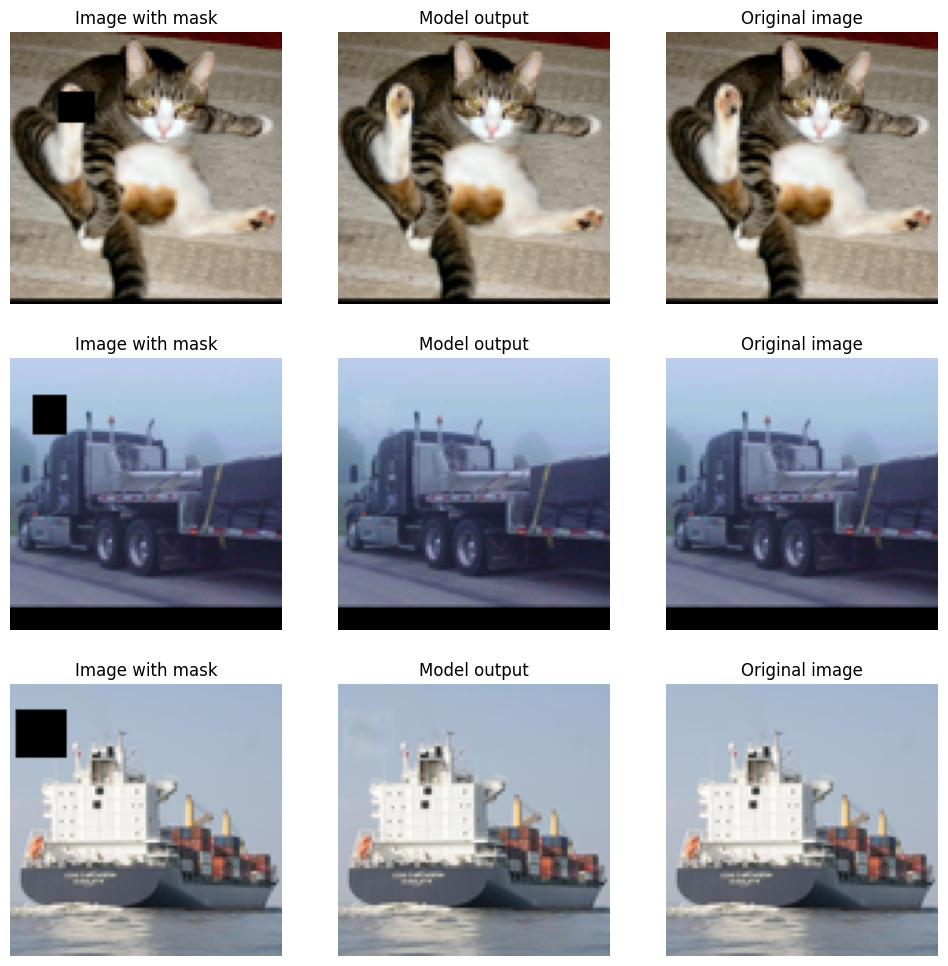

In [ ]:
# Create a figure with three subplots
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
j = 3
inds = [j, j + 1, j + 2]
for i in range(3):
    image1, image2, image3 = None, None, None

    inx = inds[i]

    image1 = stl10_test.get_masked_image(inx).permute((1,2,0))
    image3 = stl10_test.get_image(inx).permute((1,2,0))

    # Will be done in future
    with torch.no_grad():
        model.eval()
        # result = model(img_t.view(1, 3, 32, 32).to(device))
        image2 = model(stl10_test.get_masked_image(inx).view(1, 3, 96, 96).to(device)).cpu()[0].permute(1, 2, 0)
        # print(result[0].shape)
        # plt.imshow(result[0].permute((1,2,0)).cpu())



    axes[i][0].imshow(image1)
    axes[i][0].set_title('Image with mask')

    axes[i][1].imshow(image2)
    axes[i][1].set_title('Model output')

    axes[i][2].imshow(image3)
    axes[i][2].set_title('Original image')

# Remove axis labels and ticks
for ax in axes.flat:
    ax.axis('off')

# Display the plot
plt.show()

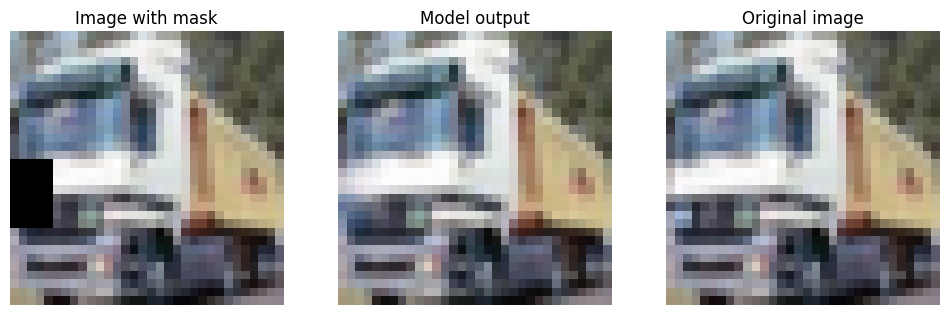

In [ ]:
image1, image2, image3 = None, None, None

inx = 1

image1 = cifar10_test.get_masked_image(inx).permute((1,2,0))
image3 = cifar10_test.get_image(inx).permute((1,2,0))

# Will be done in future
with torch.no_grad():
    model.eval()
    # result = model(img_t.view(1, 3, 32, 32).to(device))
    image2 = model(cifar10_test.get_masked_image(inx).view(1, 3, 32, 32).to(device)).cpu()[0].permute(1, 2, 0)
    # print(result[0].shape)
    # plt.imshow(result[0].permute((1,2,0)).cpu())


# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(image1)
axes[0].set_title('Image with mask')

axes[1].imshow(image2)
axes[1].set_title('Model output')

axes[2].imshow(image3)
axes[2].set_title('Original image')

# Remove axis labels and ticks
for ax in axes:
    ax.axis('off')

# Display the plot
plt.show()

In [ ]:
torch.save(model.state_dict(), "best.pt")